<a href="https://colab.research.google.com/github/swapniladnak2510/Transfer-learning-with-InceptionV3/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapniladnak","key":"6a396b4561573e70056818c5fabba9c7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:56<00:00, 46.5MB/s]
100% 2.29G/2.29G [00:56<00:00, 43.5MB/s]


In [6]:
!unzip -q /content/chest-xray-pneumonia.zip

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-29 12:19:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  72.0MB/s    in 1.2s    

2020-08-29 12:20:01 (72.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [49]:
import tensorflow as tf
import os
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

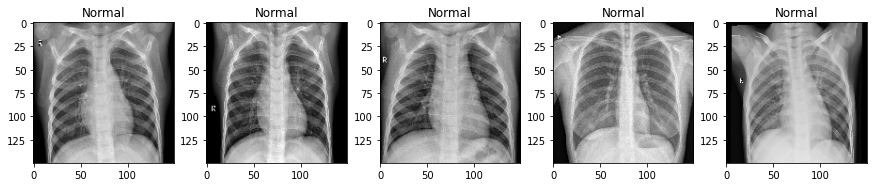

In [71]:
j=1
plt.figure(figsize=(15,15))
for im in glob('/content/chest_xray/test/NORMAL/*')[:5]:
  ax = plt.subplot(5,5,j)
  i=tf.keras.preprocessing.image.load_img(im,target_size=(150,150,3))
  plt.imshow(i)
  plt.title('Normal')
  j=j+1

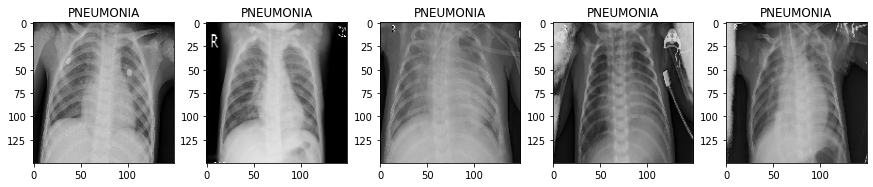

In [72]:
j=1
plt.figure(figsize=(15,15))
for im in glob('/content/chest_xray/test/PNEUMONIA/*')[:5]:
  ax = plt.subplot(5,5,j)
  i=tf.keras.preprocessing.image.load_img(im,target_size=(150,150,3))
  plt.imshow(i)
  plt.title('PNEUMONIA')
  j=j+1

In [9]:
model=InceptionV3(include_top=False,weights=None,input_shape=(150,150,3))

In [10]:
model.load_weights("/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [11]:
for layers in model.layers:
  layers.trainable=False

In [12]:
output=model.get_layer('mixed7')

In [13]:
output=output.output

In [14]:
a=tf.keras.layers.Flatten()(output)
a=tf.keras.layers.Dense(512,activation='relu')(a)
a=tf.keras.layers.Dropout(0.2)(a)
a=tf.keras.layers.Dense(1,activation='sigmoid')(a)

In [15]:
model=Model(model.input,a)

In [16]:
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
train_dir='/content/chest_xray/train'
test_dir='/content/chest_xray/test'
val_dir='/content/chest_xray/val'

In [18]:
train_norm=len(os.listdir('/content/chest_xray/train/NORMAL'))

In [19]:
train_pneu=len(os.listdir('/content/chest_xray/train/PNEUMONIA'))

In [75]:
res=['Normal' for i in range(train_norm)]
res.extend(['PNEUMONIA' for i in range(train_pneu)])

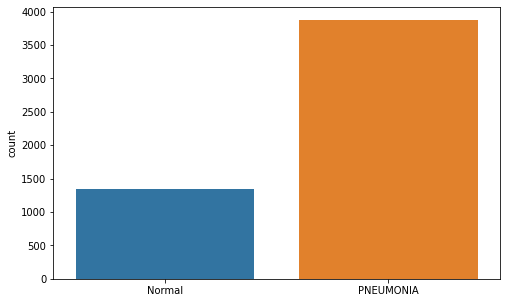

In [76]:
plt.figure(figsize=(8,5))
sns.countplot(res)

In [22]:
train_gen=ImageDataGenerator(rescale=1/255,horizontal_flip=True,zoom_range=0.2,shear_range=0.2,fill_mode='nearest')
test_gen=ImageDataGenerator(rescale=1/255)
valid_gen=ImageDataGenerator(rescale=1/255)

In [23]:
train=train_gen.flow_from_directory(train_dir,class_mode='binary',target_size=(150,150))
test=test_gen.flow_from_directory(test_dir,class_mode='binary',target_size=(150,150))
valid=valid_gen.flow_from_directory(val_dir,class_mode='binary',target_size=(150,150))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [24]:
out=model.fit(train,epochs=10,validation_data=valid,batch_size=30,verbose=1)

Epoch 1/10
163/163 [==============================] - 88s 538ms/step - loss: 0.5550 - accuracy: 0.9032 - val_loss: 0.2945 - val_accuracy: 0.8750
Epoch 2/10
163/163 [==============================] - 86s 530ms/step - loss: 0.1703 - accuracy: 0.9448 - val_loss: 0.6939 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 87s 531ms/step - loss: 0.1314 - accuracy: 0.9513 - val_loss: 0.3121 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 86s 525ms/step - loss: 0.1229 - accuracy: 0.9565 - val_loss: 0.2023 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 87s 533ms/step - loss: 0.1082 - accuracy: 0.9622 - val_loss: 0.1424 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 87s 533ms/step - loss: 0.1029 - accuracy: 0.9615 - val_loss: 0.1086 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 86s 530ms/step - loss: 0.0976 - accuracy: 0.9661 - val_loss: 0.1507 - val_ac

In [25]:
model.evaluate(test)

20/20 [==============================] - 6s 313ms/step - loss: 0.2835 - accuracy: 0.9279


[0.283479243516922, 0.9278846383094788]

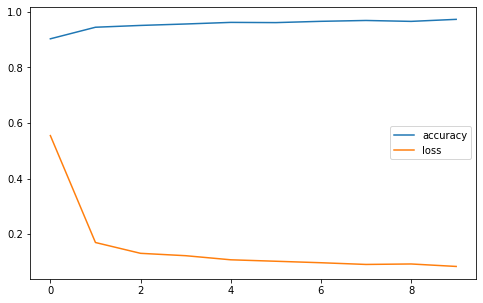

In [39]:
plt.figure(figsize=(8,5))
acc=out.history['accuracy']
loss=out.history['loss']
plt.plot(range(10),acc,label='accuracy')
plt.plot(range(10),loss,label='loss')
plt.legend()

In [97]:
true=[]
for i in test.index_array:
  true.append(test.labels[i])

In [99]:
pred=np.round(model.predict(test))

In [101]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       234
           1       0.91      0.98      0.94       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



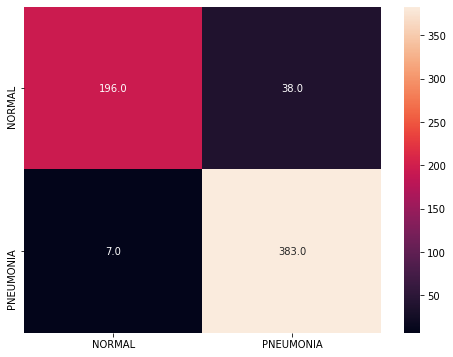

In [109]:
confusion_met=confusion_matrix(true,pred)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_met,annot=True,fmt='0.1f',xticklabels=['NORMAL','PNEUMONIA'],yticklabels=['NORMAL','PNEUMONIA'])